In [120]:
import os
import re
import biom
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from biom import Table

In [121]:
table = biom.load_table("../../data/pretraining_table_filter.biom")

In [122]:
table

14093 x 210090 <class 'biom.table.Table'> with 25341594 nonzero entries (0% dense)

In [123]:
fid = table.ids(axis="observation")

In [77]:
table

14093 x 210090 <class 'biom.table.Table'> with 25341594 nonzero entries (0% dense)

In [105]:
metadata = pd.read_csv("../../data/metadata_filter.txt", sep="\t")

In [107]:
metadata.shape

(210090, 7)

In [106]:
metadata.head()

,sample_id,project,instrument,geo_loc_name,region,seq_region,sample_type
0,10532.00954e18.1dcf.40fc.a52e.255f5cda6f9c,qiita_10532,MiSeq Illumina,USA:AZ,Europe and Northern America,V4,feces
1,10532.00cdbb86.acbd.429c.abe3.12f19990314a,qiita_10532,MiSeq Illumina,USA:AZ,Europe and Northern America,V4,feces
2,10532.00e6b118.fb6e.4022.96d1.62e553d9b40c,qiita_10532,MiSeq Illumina,USA:AZ,Europe and Northern America,V4,feces
3,10532.0129210b.a355.4608.8aac.7e6d637c0b5c,qiita_10532,MiSeq Illumina,USA:AZ,Europe and Northern America,V4,feces
4,10532.0476f5aa.a4f4.4835.ada1.4e72fb601e0a,qiita_10532,MiSeq Illumina,USA:AZ,Europe and Northern America,V4,feces


### get silve taxonomy

In [81]:
tax = pd.read_csv("Data/taxmap_slv_ssu_ref_nr_138.2.txt", sep="\t", low_memory=False)
acc = []
for i in range(tax.shape[0]):
    temp = tax.iloc[i]
    acc.append(f"{temp[0]}.{temp[1]}.{temp[2]}")

tax = tax.loc[:, "path"].str.split(';', expand=True)
tax.index = acc
tax = tax.iloc[:, 0: 7]
tax = tax.loc[fid, ]
tax.columns = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

/tmp/ipykernel_217083/2776229720.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  acc.append(f"{temp[0]}.{temp[1]}.{temp[2]}")


In [82]:
tax = tax.loc[table.ids(axis="observation")]

In [83]:
tax.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
AAAA02020714.1.1202,Bacteria,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,
AAFJ01000001.39328.40836,Bacteria,Campylobacterota,Campylobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,
AAQK01001555.694.2198,Bacteria,Bacillota,Bacilli,Erysipelotrichales,Erysipelotrichaceae,Solobacterium,
AAQK01003909.1492.2988,Bacteria,Actinomycetota,Coriobacteriia,Coriobacteriales,Atopobiaceae,Tractidigestivibacter,
AATC01000018.2.1513,Bacteria,Bacillota,Clostridia,Lachnospirales,Lachnospiraceae,Incertae Sedis,


### samples of reads

In [85]:
sample_sums = table.sum(axis='sample')

In [86]:
read_depth = pd.DataFrame({"sample_nums":sample_sums})
read_depth.to_csv("Data/read_depth_samples.csv", index=None, header=None)

###  Taxonomy

In [89]:
sample_ids = table.ids(axis='sample') 

In [90]:
def count_taxonomy_samples(level):
    level_counts = merged_df.groupby(level)[sample_ids].apply(
        lambda x: (x > 0).any(axis=0).sum()
    )
    return level_counts.to_frame(name=f"{level}_Samples")

abundance_df = table.to_dataframe()
merged_df = abundance_df.merge(tax, left_index=True,right_index=True)

taxonomy_levels = ['Phylum', 'Class', 'Order', 'Family', 'Genus']
result_dfs = [count_taxonomy_samples(level) for level in taxonomy_levels]

In [91]:
final_df = pd.concat(result_dfs, axis=1, join='outer').fillna(0).astype(int)

final_df.sort_values('Phylum_Samples', ascending=False, inplace=True)

taxonomy_mapping = {}
for level in ['Class', 'Order', 'Family', 'Genus']:
    mapping = (
        tax.groupby(level)['Phylum']
        .agg(lambda x: x.mode()[0] if not x.mode().empty else '(Unassigned)')
        .to_dict()
    )
    taxonomy_mapping[level] = mapping

In [92]:
final_df.to_csv("Data/tax_num_samples.csv")
with open("Data/taxonomy_mapping.json", "w", encoding="utf-8") as f:
    json.dump(taxonomy_mapping, f, ensure_ascii=False, indent=4)

/tmp/ipykernel_217083/3476425968.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


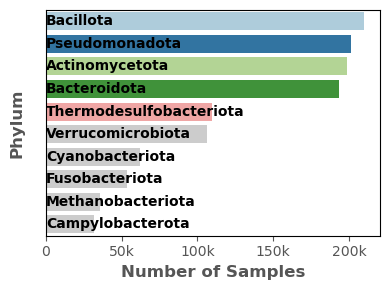

/tmp/ipykernel_217083/3476425968.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


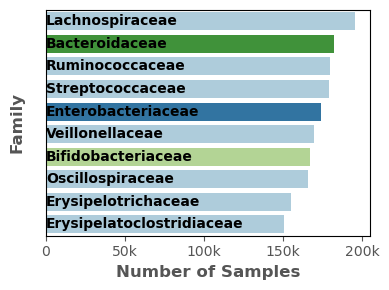

/tmp/ipykernel_217083/3476425968.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


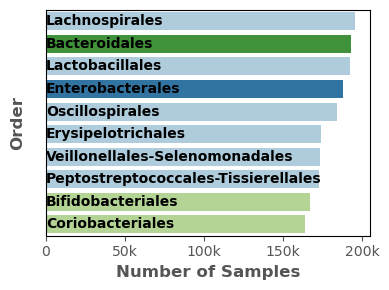

In [93]:
PHYLUM_COLORS = {}
TOP_PHYLA = []

def plot_top_taxa(level, top_n=10):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(4, 3), facecolor='white')
    ax.set_facecolor('white')
    
    data = final_df[f'{level}_Samples'].sort_values(ascending=False).head(top_n)
    data.index = data.index.str.strip() 
    
    global PHYLUM_COLORS, TOP_PHYLA
    if level == 'Phylum':
        TOP_PHYLA = data.index[:5].tolist()
        phylum_palette = sns.color_palette("Paired", 5)
        PHYLUM_COLORS = {p: c for p, c in zip(TOP_PHYLA, phylum_palette)}
        colors = [PHYLUM_COLORS.get(p, '#CCCCCC') for p in data.index]
    else:
        colors = []
        color_mapper = taxonomy_mapping.get(level, {})
        for taxon in data.index:
            clean_taxon = taxon.strip().lower()  
            phylum = color_mapper.get(
                taxon,  
                color_mapper.get(clean_taxon, '(Unassigned)') 
            )
            colors.append(PHYLUM_COLORS.get(phylum, '#CCCCCC'))
    
    ax = sns.barplot(
        x=data.values,
        y=data.index,
        palette=colors,
        orient='h'
    )
    
    ax.yaxis.set_ticks([])
    plt.ylabel(level, 
             fontdict={'fontweight': 'bold', 'fontsize': 12},
             labelpad=15)

    for i, (value, name) in enumerate(zip(data.values, data.index)):
        ax.text(0.01, i, name, 
               ha='left', va='center', 
               fontsize=10, color='black',
               fontweight='bold')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(
        lambda x, _: f"{int(x/1000)}k" if x >= 1000 else f"{int(x)}"
    ))
    plt.xlim(0, data.max()*1.05)

    ax.grid(which='major', axis='both', linestyle='--', alpha=0.7)
    ax.grid(which='minor', axis='both', linestyle=':', alpha=0.4)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.8)
    
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_top_taxa('Phylum')  
    plot_top_taxa('Family')
    plot_top_taxa('Order')

In [94]:
tax_reset = tax.reset_index(names=['fid'])

In [95]:
top_phyla = final_df.index[:5].tolist()

In [119]:
# top 5 Phylum 
top_phyla = final_df.index[:5].tolist()

phyla_abundance = abundance_df.merge(
    tax_reset[['fid', 'Phylum']],
    left_index=True,
    right_on='fid'
).drop(columns=['fid'])

phyla_abundance = phyla_abundance.groupby('Phylum').sum().T

phyla_abundance_tss = phyla_abundance.div(phyla_abundance.sum(axis=1), axis=0) * 100


phyla_abundance_top = phyla_abundance_tss[top_phyla]
phyla_abundance_top.head()

Phylum,Bacillota,Pseudomonadota,Actinomycetota,Bacteroidota,Thermodesulfobacteriota
10532.00954e18.1dcf.40fc.a52e.255f5cda6f9c,41.047359,0.543783,1.779653,56.026102,0.32627
10532.00cdbb86.acbd.429c.abe3.12f19990314a,22.301178,32.103572,0.0,43.113015,0.691132
10532.00e6b118.fb6e.4022.96d1.62e553d9b40c,16.551861,44.025699,0.715327,37.336071,1.159094
10532.0129210b.a355.4608.8aac.7e6d637c0b5c,59.966865,0.831677,0.970842,35.530152,1.222664
10532.0476f5aa.a4f4.4835.ada1.4e72fb601e0a,77.003053,3.84241,3.517232,11.96965,0.030969


In [97]:
phyla_abundance_top.to_csv("Data/phyla_abundance_top.csv")

In [98]:
phyla_abundance_top

Phylum,Bacillota,Pseudomonadota,Actinomycetota,Bacteroidota,Thermodesulfobacteriota
10532.00954e18.1dcf.40fc.a52e.255f5cda6f9c,41.047359,0.543783,1.779653,56.026102,0.32627
10532.00cdbb86.acbd.429c.abe3.12f19990314a,22.301178,32.103572,0.0,43.113015,0.691132
10532.00e6b118.fb6e.4022.96d1.62e553d9b40c,16.551861,44.025699,0.715327,37.336071,1.159094
10532.0129210b.a355.4608.8aac.7e6d637c0b5c,59.966865,0.831677,0.970842,35.530152,1.222664
10532.0476f5aa.a4f4.4835.ada1.4e72fb601e0a,77.003053,3.84241,3.517232,11.96965,0.030969
...,...,...,...,...,...
SRS9736998,82.753471,1.087074,2.362501,13.671833,0.0
SRS9736999,66.980839,2.188248,1.457614,28.975104,0.286774
SRS9737000,63.130112,13.741016,0.817844,18.969021,1.384139
SRS9737001,73.953635,3.52094,2.128735,20.05685,0.260249


### shannon

In [101]:
rarefied_biom = table.subsample(5000, by_id=False)

In [99]:
from skbio.diversity import alpha_diversity

In [102]:
adiv_shannon = alpha_diversity('shannon', rarefied_biom.to_dataframe().T, rarefied_biom.ids(axis="sample"), base=np.e)
print(adiv_shannon.head(),adiv_shannon.median())

10532.00954e18.1dcf.40fc.a52e.255f5cda6f9c    3.527243
10532.00cdbb86.acbd.429c.abe3.12f19990314a    3.290201
10532.00e6b118.fb6e.4022.96d1.62e553d9b40c    2.569322
10532.0129210b.a355.4608.8aac.7e6d637c0b5c    4.087009
10532.0476f5aa.a4f4.4835.ada1.4e72fb601e0a    4.027897
dtype: float64 3.133043987553001


In [108]:
metadata = metadata.set_index("sample_id")

sample_ids = rarefied_biom.ids(axis="sample")
metadata.loc[sample_ids, "shannon"] = adiv_shannon

metadata.head()

,project,instrument,geo_loc_name,region,seq_region,sample_type,shannon
sample_id,,,,,,,
10532.00954e18.1dcf.40fc.a52e.255f5cda6f9c,qiita_10532,MiSeq Illumina,USA:AZ,Europe and Northern America,V4,feces,3.527243
10532.00cdbb86.acbd.429c.abe3.12f19990314a,qiita_10532,MiSeq Illumina,USA:AZ,Europe and Northern America,V4,feces,3.290201
10532.00e6b118.fb6e.4022.96d1.62e553d9b40c,qiita_10532,MiSeq Illumina,USA:AZ,Europe and Northern America,V4,feces,2.569322
10532.0129210b.a355.4608.8aac.7e6d637c0b5c,qiita_10532,MiSeq Illumina,USA:AZ,Europe and Northern America,V4,feces,4.087009
10532.0476f5aa.a4f4.4835.ada1.4e72fb601e0a,qiita_10532,MiSeq Illumina,USA:AZ,Europe and Northern America,V4,feces,4.027897


In [109]:
metadata = metadata.loc[sample_ids]
metadata["read_depth"] = sample_sums
metadata.to_csv("meta_data_include_shannon.csv", index=None)

In [110]:
metadata.shape

(210090, 8)

### prevalence

In [112]:
table = biom.load_table("../../data/pretraining_table_filter.biom")

In [113]:
fid = table.ids(axis="observation")

In [114]:
import matplotlib.ticker as ticker
prevalence = table.nonzero_counts(axis="observation") / table.shape[1]

Text(0, 0.5, 'Density')

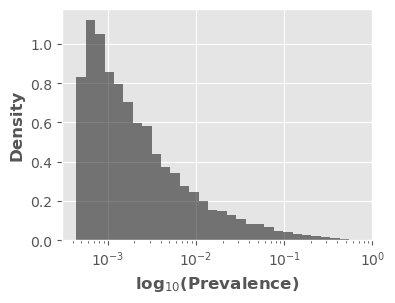

In [116]:
plt.figure(figsize=(4, 3), facecolor='white')
plt.style.use('ggplot')
ax = sns.histplot(
    x=prevalence,
    stat='density',
    log_scale=True,
    color='black',
    alpha=0.5,
    kde=False,
    bins=30,
    edgecolor='none'
)

ax.set_xlabel('log$_{10}$(Prevalence)', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')

In [118]:
prevalence = pd.DataFrame({"prevalence":prevalence})
prevalence.to_csv("Data/prevalence.csv", index=None)